Import Libraries

In [101]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

np.random.seed(42)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Image Processing

In [102]:
def load_and_preprocess_data(dataset_path):
    images = []
    labels = []
    classes = sorted(os.listdir(dataset_path))

    print(f"Classes found: {classes}")

    for label_id, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)

            img = cv2.imread(img_path)

            if img is not None:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                resized = cv2.resize(gray, (32, 32))

                flattened = resized.flatten()

                images.append(flattened)
                labels.append(label_id)

    # Convert to numpy arrays
    X = np.array(images)/255
    y = np.array(labels)

    return X, y, classes

dataset_path = "/content/drive/MyDrive/Colab Notebooks/animal_dataset"

try:
    X, y, class_names = load_and_preprocess_data(dataset_path)
    print(f"Data Loaded: {X.shape[0]} images, {X.shape[1]} features.")

    if len(X) != 300:
        print(f"Warning: Expected 300 images, found {len(X)}.")

except Exception as e:
    print(f"Error loading data: {e}. Please check your path.")

Classes found: ['cat', 'dog', 'panda']
Data Loaded: 300 images, 1024 features.


Distance Metrics

In [103]:
def euclidean_distance(row1, row2):
    return np.sqrt(np.sum((row1 - row2)**2))

def manhattan_distance(row1, row2):
    return np.sum(np.abs(row1 - row2))

KNN Implementation

In [104]:
def get_neighbors(X_train, y_train, test_row, k, distance_metric):
    distances = []
    for i in range(len(X_train)):
        if distance_metric == 'l1':
            dist = manhattan_distance(test_row, X_train[i])
        else:
            dist = euclidean_distance(test_row, X_train[i])
        distances.append((dist, y_train[i]))

    distances.sort(key=lambda x: x[0])

    neighbors = distances[:k]
    return neighbors

def predict_classification(X_train, y_train, test_row, k, distance_metric='l2'):
    neighbors = get_neighbors(X_train, y_train, test_row, k, distance_metric)
    output_values = [row[-1] for row in neighbors]

    class_counts = {}

    for label in output_values:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

    prediction = -1
    max_votes = -1

    for label, count in class_counts.items():
        if count > max_votes:
            max_votes = count
            prediction = label

    return prediction

def knn_evaluate(X_train, y_train, X_val, y_val, k, distance_metric):
    predictions = []
    for row in X_val:
        output = predict_classification(X_train, y_train, row, k, distance_metric)
        predictions.append(output)

    accuracy = np.sum(predictions == y_val) / len(y_val)
    return accuracy

5-Fold Cross-Validation

In [105]:

np.random.seed(42)

num_folds = 5
fold_size = int(len(X) / num_folds)
indices = np.arange(len(X))
np.random.shuffle(indices)

k_values = range(1, 21, 2)
l1_accuracies = []
l2_accuracies = []

best_accuracy = 0.0
best_k = None
best_metric = None


print("Starting 5-Fold Cross-Validation...")

for k in k_values:
    fold_l1_acc = []
    fold_l2_acc = []

    for i in range(num_folds):
        val_indices = indices[i * fold_size : (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        X_train_fold, X_val_fold = X[train_indices], X[val_indices]
        y_train_fold, y_val_fold = y[train_indices], y[val_indices]


        acc_l1 = knn_evaluate(X_train_fold, y_train_fold, X_val_fold, y_val_fold, k, 'l1')
        fold_l1_acc.append(acc_l1)

        acc_l2 = knn_evaluate(X_train_fold, y_train_fold, X_val_fold, y_val_fold, k, 'l2')
        fold_l2_acc.append(acc_l2)


    avg_l1 = np.mean(fold_l1_acc)
    avg_l2 = np.mean(fold_l2_acc)

    l1_accuracies.append(avg_l1)
    l2_accuracies.append(avg_l2)

    if avg_l1 > best_accuracy:
        best_accuracy = avg_l1
        best_k = k
        best_metric = 'l1'

    if avg_l2 > best_accuracy:
        best_accuracy = avg_l2
        best_k = k
        best_metric = 'l2'


    print(f"K={k}: L1 Avg Acc: {avg_l1:.4f}, L2 Avg Acc: {avg_l2:.4f}")

print("-" * 30)
print(f"Best K found: {best_k}")
print(f"Best Metric: {best_metric}")
print(f"Highest Accuracy: {best_accuracy:.4f}")
print("-" * 30)

Starting 5-Fold Cross-Validation...
K=1: L1 Avg Acc: 0.3467, L2 Avg Acc: 0.3233
K=3: L1 Avg Acc: 0.3767, L2 Avg Acc: 0.3567
K=5: L1 Avg Acc: 0.3867, L2 Avg Acc: 0.3667
K=7: L1 Avg Acc: 0.3867, L2 Avg Acc: 0.3633
K=9: L1 Avg Acc: 0.4100, L2 Avg Acc: 0.3700
K=11: L1 Avg Acc: 0.4333, L2 Avg Acc: 0.3967
K=13: L1 Avg Acc: 0.4433, L2 Avg Acc: 0.3600
K=15: L1 Avg Acc: 0.4267, L2 Avg Acc: 0.3833
K=17: L1 Avg Acc: 0.4200, L2 Avg Acc: 0.3800
K=19: L1 Avg Acc: 0.4433, L2 Avg Acc: 0.3767
------------------------------
Best K found: 13
Best Metric: l1
Highest Accuracy: 0.4433
------------------------------


Plotting

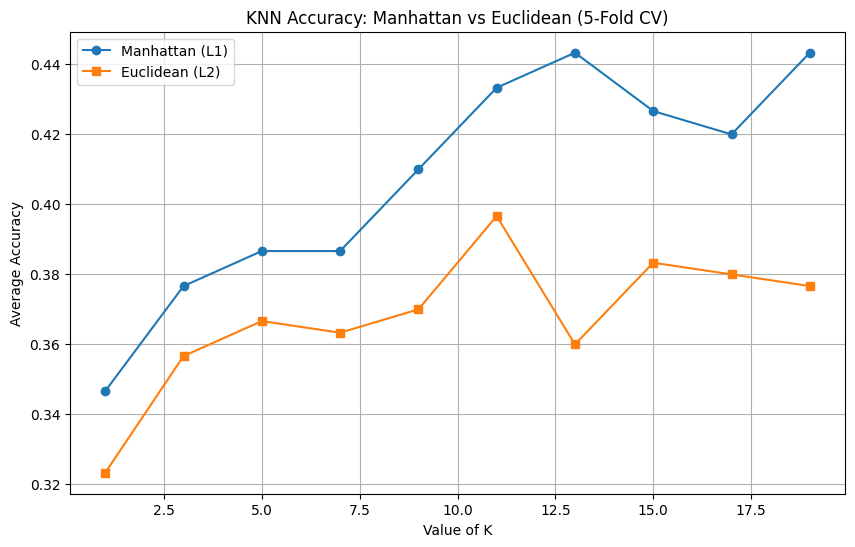

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, l1_accuracies, marker='o', label='Manhattan (L1)')
plt.plot(k_values, l2_accuracies, marker='s', label='Euclidean (L2)')

plt.title('KNN Accuracy: Manhattan vs Euclidean (5-Fold CV)')
plt.xlabel('Value of K')
plt.ylabel('Average Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Top 5 Predictions

Generating predictions using Best Model: K=13, Metric=l1...


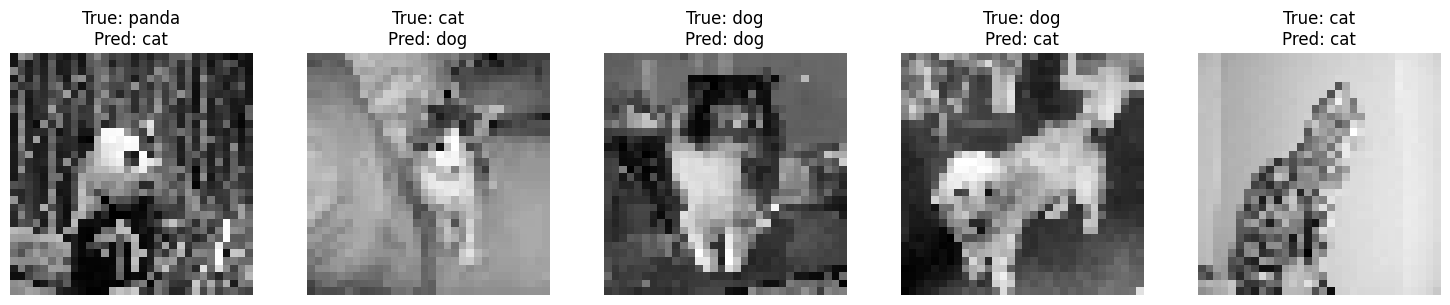

In [107]:


print(f"Generating predictions using Best Model: K={best_k}, Metric={best_metric}...")


sample_indices = np.random.choice(len(X_val_fold), 5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, idx in enumerate(sample_indices):
    test_image = X_val_fold[idx]
    actual_label = class_names[y_val_fold[idx]]

    prediction_idx = predict_classification(
        X_train_fold,
        y_train_fold,
        test_image,
        k=best_k,
        distance_metric=best_metric
    )


    predicted_label = class_names[prediction_idx]

    # Display
    img_display = test_image.reshape(32, 32)
    axes[i].imshow(img_display, cmap='gray')
    axes[i].set_title(f"True: {actual_label}\nPred: {predicted_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Based on the 5-fold cross-validation, Manhattan (L1) distance significantly outperformed Euclidean (L2) for this grayscale dataset. Manhattan demonstrated a stable positive trend, achieving a peak average accuracy of 44.5% at K=19, whereas Euclidean peaked lower at ~39.5% (K=11) and degraded with higher K values.